# Toyota Yaris II -  price prediction (draft)


Notebook do analizy cen samochodu Yaris II

## Wczytanie i przegląd danych

In [172]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_view_data():
    sql_query = """SELECT * FROM v_cars"""
    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_data():
    sql_query ="""
SELECT 
    all_offers.offer_id,otomoto_all.s_date, otomoto_all.e_date, all_offers.private_business, all_offers.region,
    all_offers.city, all_offers.model, all_offers.year, all_offers.mileage, all_offers.engine_capacity, all_offers.vin,
    all_offers.fuel_type, all_offers.engine_power, all_offers.gearbox, all_offers.transmission, all_offers.door_count,
    all_offers.nr_seats, all_offers.color, all_offers.features,otomoto_all.price, all_offers.price_raw, all_offers.currency, 
    all_offers.country_origin, all_offers.registration
FROM 
    otomoto_all, all_offers
WHERE 
    otomoto_all.uid = all_offers.uid; 
"""

    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

#%time df = get_data() #~13 ms
%time df = get_view_data() #~13 ms

#%time for i in range(3000): df = get_data()

df.head(3)

Wall time: 17 ms


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,transmission,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration
0,6005738641,2020-04-17,2020-05-11,business,malopolskie,krakow,yaris,2009,111000,1000,...,front-wheel,5,5,grey,0,6200,6200.0,0,f,0
1,6018694885,2020-04-17,2020-05-11,business,warminsko-mazurskie,ostroda,yaris,2008,45706,998,...,0,3,5,white,abs central-lock electronic-immobiliser front-...,4700,4700.0,0,pl,0
2,6025678407,2020-04-17,2020-05-11,business,mazowieckie,milanowek,yaris,2009,174000,1300,...,0,5,5,silver,abs cd central-lock front-electric-windows ele...,19800,19800.0,0,0,0


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer_id          357 non-null    int64  
 1   s_date            357 non-null    object 
 2   e_date            357 non-null    object 
 3   private_business  357 non-null    object 
 4   region            357 non-null    object 
 5   city              357 non-null    object 
 6   model             357 non-null    object 
 7   year              357 non-null    int64  
 8   mileage           357 non-null    int64  
 9   engine_capacity   357 non-null    int64  
 10  vin               357 non-null    object 
 11  fuel_type         357 non-null    object 
 12  engine_power      357 non-null    int64  
 13  gearbox           357 non-null    object 
 14  transmission      357 non-null    object 
 15  door_count        357 non-null    int64  
 16  nr_seats          357 non-null    int64  
 1

In [174]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

## Porządkowanie danych

In [120]:
# offer_id - numer oferty
print('offer_id: ', df['offer_id'].dtypes)
print('offer_id: ', df['offer_id'].nunique(), 'MIN:', df['offer_id'].min(), 'MAX:', df['offer_id'].max())

df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')

offer_id:  int64
offer_id:  303 MIN: 6005738641 MAX: 6074411247


### s_date / e_date

In [121]:
# s_date - data publikacji ogłoszenia 
# e_date - data końca ogłoszenia

print('s_date: ', df['s_date'].dtypes)
print('e_date: ', df['e_date'].dtypes)

s_date:  object
e_date:  object


In [122]:
df['s_date'] = pd.to_datetime(df['s_date']) 
df['e_date'] = pd.to_datetime(df['e_date'])
print('s_date: ', df['s_date'].dtypes)
print('e_date: ', df['e_date'].dtypes)

s_date:  datetime64[ns]
e_date:  datetime64[ns]


### private_business

In [123]:
# private_business

print('private_business: ', df['private_business'].dtypes)
print('private_business: ', df['private_business'].unique())

private_business:  object
private_business:  ['business' 'private']


In [124]:
# business : 1
# private : 0

df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business' )
df['private_business'] = df['private_business'].astype(int)

print('private_business: ', df['private_business'].dtypes)
print('private_business: ', df['private_business'].unique())

private_business:  int32
private_business:  [1 0]


### Region / City / Model

In [125]:
# region 
print('region: ', df['region'].dtypes)
print('region: ', df['region'].unique())

region:  object
region:  ['malopolskie' 'warminsko-mazurskie' 'mazowieckie' 'dolnoslaskie'
 'wielkopolskie' 'slaskie' 'podkarpackie' 'podlaskie' 'lodzkie'
 'zachodniopomorskie' 'lubelskie' 'swietokrzyskie' 'opolskie'
 'kujawsko-pomorskie' 'lubuskie' 'pomorskie']


In [126]:
# city
print('city: ', df['city'].dtypes)
print('city: ', df['city'].nunique())

city:  object
city:  159


In [127]:
# model
print('model: ', df['model'].dtypes)
print('model: ', df['model'].unique())

model:  object
model:  ['yaris']


In [128]:
# year - lata produkcji Yaris II: 2005 - 2011
print('year: ', df['year'].dtypes)
print('year: ', df['year'].unique())

year:  int64
year:  [2009 2008 2006 2005 2007 2010 2011 2002 2014 2016]


In [129]:
# mileage
print('mileage: ', df['mileage'].dtypes)
print('mileage: ', df['mileage'].nunique())
print('MIN: ', df['mileage'].min(), 'MAX: ', df['mileage'].max())

mileage:  int64
mileage:  217
MIN:  9100 MAX:  410000


### Engine Capacity

In [130]:
# engine capacity
print('engine_capacity: ', df['engine_capacity'].dtypes)
print('engine_capacity: ', df['engine_capacity'].unique())

engine_capacity:  int64
engine_capacity:  [1000  998 1300 1364 1298 1400 1398 1329    0 1798 1323  966 1324  996
  988 1332 1296  999 1290 1335 1333]


Wg portalu Autocentrum w tym modelu były dostępne następujące wersje silnikowe:

Benzyna:
- 1.0  VVT-i      69KM 51kW (2005-2011) - 998 cm3, 5MT

- 1.3i VVT-i      86KM 63kW (2005-2010) - 1296 cm3, 5MT

- 1.33 Dual VVT-i 101KM 74kW (2009-2011) - 1329 cm3, 6MT

- 1.8i VVT-i      133KM 98kW (2005-2010) - 1798 cm3, 6MT

Diesel:
- 1.4 D-4D 90KM 66kW (2005-2011) - 1364 cm3, 5MT

### VIN

In [131]:
# vin
print('vin: ', df['vin'].dtypes)
print('vin: ', df['vin'].unique())

vin:  object
vin:  ['0']


W żadnym ogłoszeniu nie był podany numer VIN

In [132]:
# fuel_type
print('fuel_type: ', df['fuel_type'].dtypes)
print('fuel_type: ', df['fuel_type'].unique())

fuel_type:  object
fuel_type:  ['petrol' 'diesel' 'petrol-lpg']


In [133]:
# engine_power - Moc W KM
# 1kW = 1,36 KM
# Powinno być: Benzyna: 69, 86, 101,133 Diesel: 90 

print('engine_power: ', df['engine_power'].dtypes)
print('engine_power: ', df['engine_power'].unique())


engine_power:  int64
engine_power:  [  0 100  87  90  86  69 101  70  82 133  68  88  80  66  99  72  65 103
  85  97  67  51]


In [134]:
# gearbox

print('gearbox: ', df['gearbox'].dtypes)
print('gearbox: ', df['gearbox'].unique())

gearbox:  object
gearbox:  ['manual' 'semi-automatic' '0' 'automatic' 'automatic-sequential']


In [135]:
# transmission
# Yaris II występował wyłącznie z napędem na przód

print('transmission: ', df['transmission'].dtypes)
print('transmission: ', df['transmission'].unique())

transmission:  object
transmission:  ['front-wheel' '0' 'rear-wheel']


In [136]:
# door_count
print('door_count: ', df['door_count'].dtypes)
print('door_count: ', df['door_count'].unique())

door_count:  int64
door_count:  [5 3 0 4]


In [137]:
# nr_seats
print('nr_seats: ', df['nr_seats'].dtypes)
print('nr_seats: ', df['nr_seats'].unique())

nr_seats:  int64
nr_seats:  [5 0 6 4 2]


In [138]:
# color
print('color: ', df['color'].dtypes)
print('color: ', df['color'].unique())

color:  object
color:  ['grey' 'white' 'silver' 'red' 'blue' 'other' 'black' 'yellow-gold'
 'green' 'yellow' 'brown-beige']


In [139]:
# price
print('price: ', df['price'].dtypes)
print('price: ', df['price'].nunique())

# price_raw
print('price_raw: ', df['price_raw'].dtypes)
print('price_raw: ', df['price_raw'].nunique())

price:  int64
price:  102
price_raw:  float64
price_raw:  113


In [140]:
# currency
print('currency: ', df['currency'].dtypes)
print('currency: ', df['currency'].unique())

currency:  object
currency:  ['0']


In [141]:
# country_origin
print('country_origin: ', df['country_origin'].dtypes)
print('country_origin: ', df['country_origin'].unique())

countries = {
    'f' : 'France',
    'pl' : 'Poland',
    'd' : 'Germany',
    'b' : 'Belgium',
    'nl' : 'Nederlands',
    'a': 'Austria',
    'i' : 'Italy',
    'gb' : 'Great Britan',
    'dk' : 'Denmark',
    's' : 'Sweden'
}

country_origin:  object
country_origin:  ['f' 'pl' '0' 'd' 'b' 'nl' 'a' 'i' 'gb' 'dk' 's']


In [142]:
# registration
print('registration: ', df['registration'].dtypes)
print('registration: ', df['registration'].unique())

registration:  object
registration:  ['0' 'RST19536' 'ZGR VH37' 'RZE68062' 'FZ7305M' 'FZ7556M' 'ZDR 16488'
 'FZ7496M' 'K WV2222' 'LRY 84LR' 'KBC 72163' 'DJ91837' 'TKI8551A' 'XGK506'
 'RZE 74732' 'CG34523' 'RBR28917' 'ZMY 705AJ' 'XUM146' 'FNW53TF'
 'WY 98871' 'FMI 54886' 'WZY11627' 'TK 2396F' 'PK6174K']


---

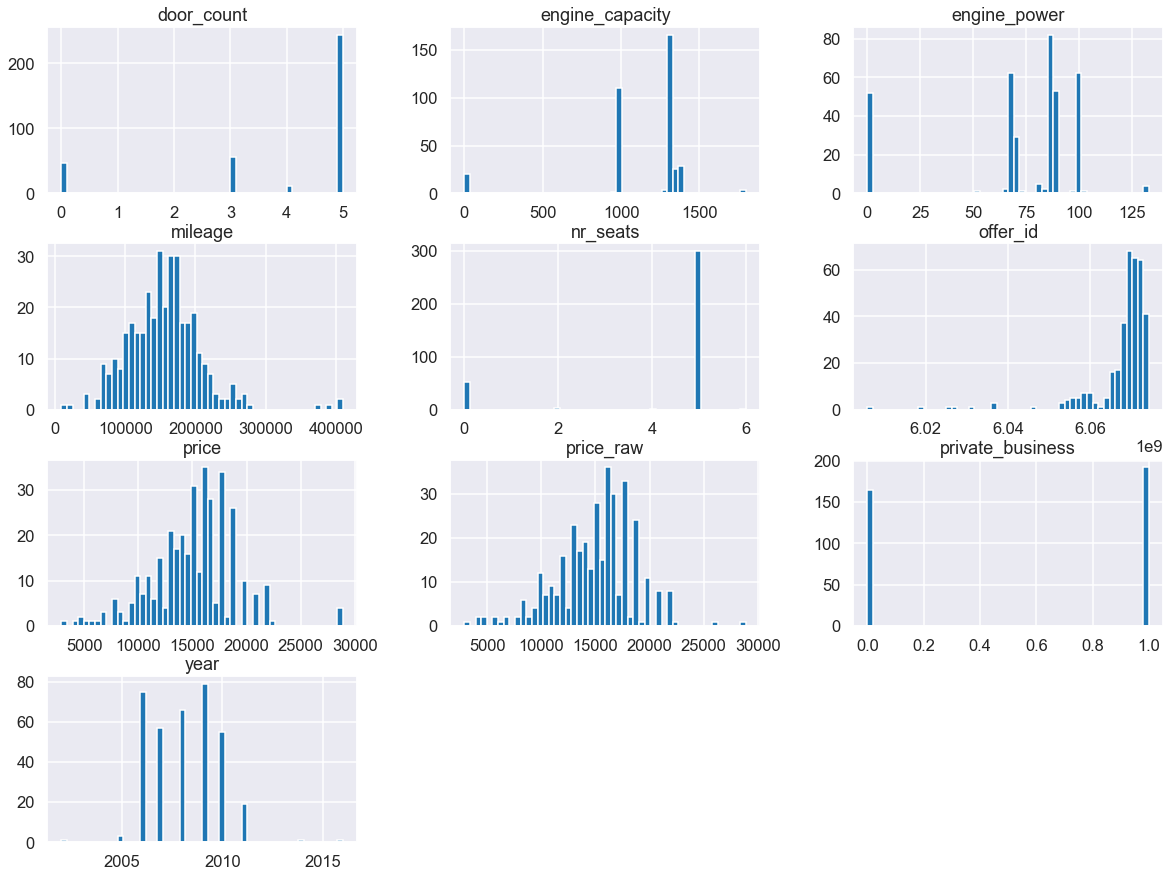

In [143]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [144]:
def optimize_df():
    #df['offer_id'] = df['offer_id'].astype(np.uint32)
    df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date']) 
    df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business')
    df['year'] = pd.to_numeric(df['year'], downcast='unsigned')
    df['mileage'] = pd.to_numeric(df['mileage'], downcast='unsigned')
    df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], downcast='unsigned')
    df['engine_power'] = pd.to_numeric(df['engine_power'], downcast='unsigned')
    df['door_count'] = pd.to_numeric(df['door_count'], downcast='unsigned')
    df['nr_seats'] = pd.to_numeric(df['nr_seats'], downcast='unsigned')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['price_raw'] = pd.to_numeric(df['price_raw'], downcast='float')
    
%time optimize_df()    

Wall time: 19 ms


## Feature engineering

In [145]:
def general_features():
    df['duration'] = (df['e_date'] - df['s_date']).dt.days.astype(np.uint16)
    df['price_chng'] = (df['price'] - df['price_raw'])
    #df['active'] = df['duration'].apply()
    
%time general_features()

Wall time: 38.6 ms


In [146]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
24,6057452887,2020-04-17,2020-05-06,False,malopolskie,miechow,yaris,2006,172000,998,...,5,silver,abs cd central-lock front-electric-windows ele...,14900.0,14900.0,0,0,0,19,0.0
227,6071058634,2020-04-17,2020-05-09,False,malopolskie,nowy-sacz,yaris,2011,190464,1329,...,5,black,abs cd central-lock front-electric-windows ele...,17899.0,17900.0,0,d,0,22,-1.0
43,6062169696,2020-04-17,2020-05-09,False,zachodniopomorskie,szczecin,yaris,2008,250000,998,...,5,silver,abs cd central-lock front-electric-windows ele...,11900.0,11900.0,0,pl,0,22,0.0


In [147]:
# Price change
df[df['price_chng']!=0].head()

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
6,6036867722,2020-04-17,2020-05-09,False,slaskie,raciborz,yaris,2008,153000,1298,...,5,red,abs cd central-lock front-electric-windows ele...,13900.0,14900.000000,0,d,0,22,-1000.000000
13,6054649805,2020-04-20,2020-05-11,False,podlaskie,suwalki,yaris,2007,178560,1300,...,5,silver,abs cd central-lock front-electric-windows ele...,15900.0,16600.000000,0,d,0,21,-700.000000
45,6064542261,2020-04-17,2020-05-05,False,malopolskie,tarnow,yaris,2008,157000,1300,...,0,grey,abs cd central-lock front-electric-windows ele...,21900.0,14999.000000,0,d,0,18,6901.000000
60,6065857762,2020-04-19,2020-05-11,False,lodzkie,sieradz,yaris,2008,270981,998,...,5,silver,abs cd electronic-rearview-mirrors electronic-...,10999.0,11500.000000,0,0,0,22,-501.000000
85,6067672282,2020-04-17,2020-05-09,False,wielkopolskie,ostrzeszow,yaris,2007,410000,998,...,2,silver,abs cd central-lock electronic-immobiliser fro...,5400.0,4390.240234,0,pl,0,22,1009.759766


Wall time: 60 ms


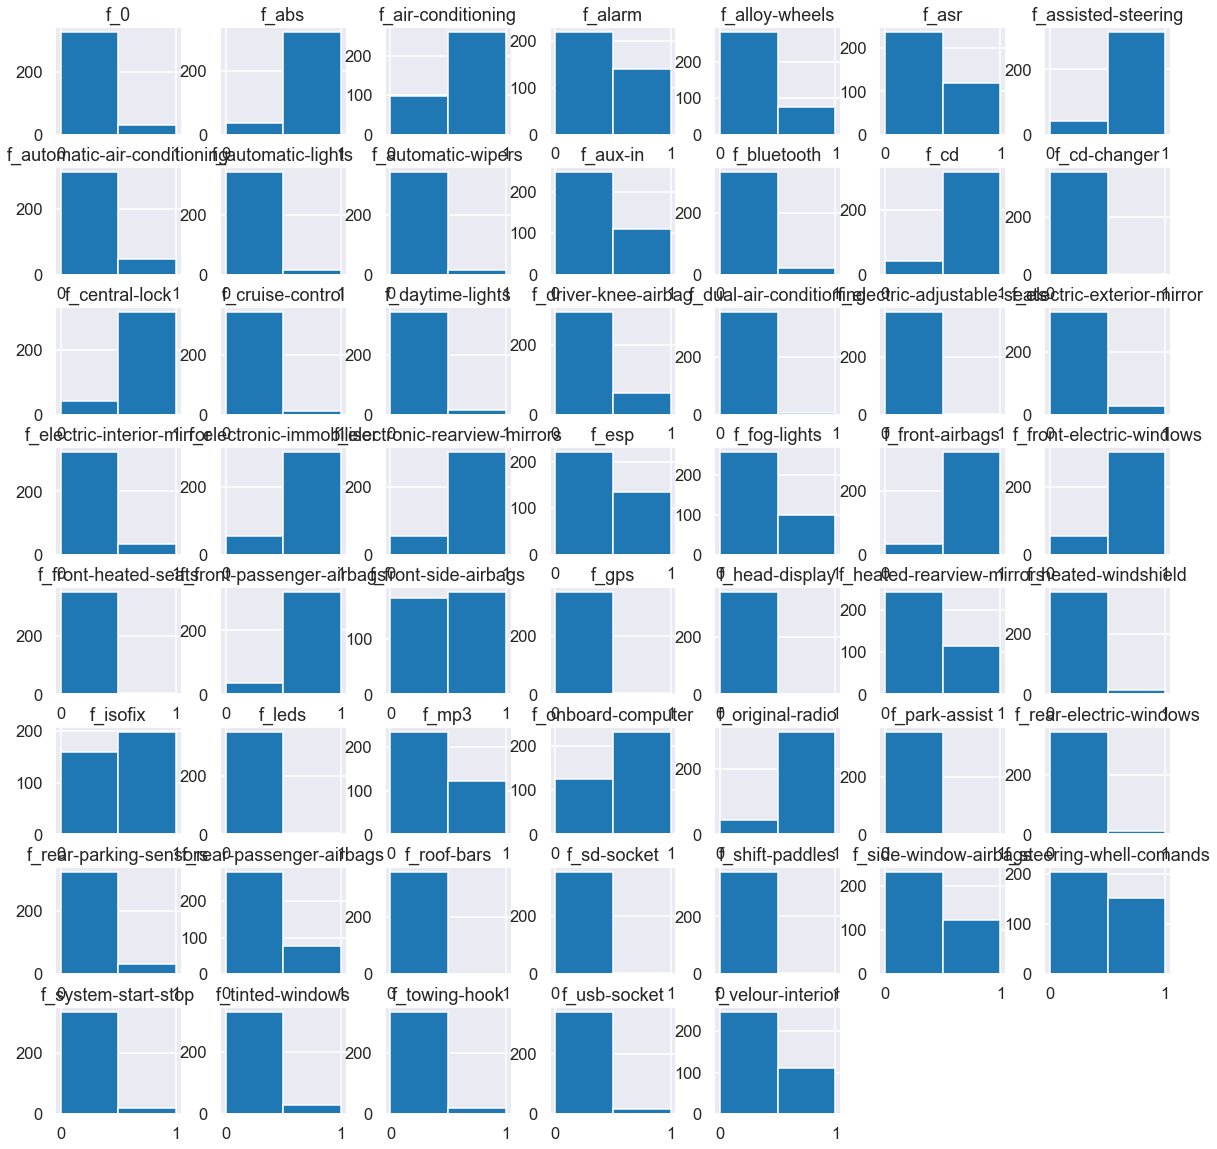

In [148]:
#car features
def benefits_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'f_{0}'.format( name.lower().strip() )

def feature_columns(): 
    benefits_series = df['features'].str.split(' ').map(benefits_to_set)
    all_benefits = {benefit for row in benefits_series for benefit in row}
    
    feat_names = [norm_name(x) for x in all_benefits]
    
    for benefit in all_benefits:
        df[ norm_name(benefit) ] = benefits_series.map(lambda x: benefit in x).astype(np.int8)
    
    return feat_names

%time f = feature_columns()


df[f].hist(bins=2,figsize=(20,20))
plt.show()

In [149]:
#df[df['f_head-display']==1]

In [150]:
# return only not empty columns
def non_empty_feats():
    for col in df.columns: 
        if col[0:2] == 'f_':
            if df[col].nunique() != 0:
                print(col)
                
#non_empty_feats()                

In [151]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_alloy-wheels,f_mp3,f_leds,f_system-start-stop,f_shift-paddles,f_front-side-airbags,f_electric-adjustable-seats,f_tinted-windows,f_air-conditioning,f_electric-interior-mirror
176,6070011917,2020-04-17,2020-04-29,False,wielkopolskie,krotoszyn,yaris,2007,220400,1400,...,0,0,0,0,0,1,0,0,1,0
50,6064879479,2020-04-17,2020-05-11,False,podkarpackie,stalowa-wola,yaris,2009,163000,1329,...,0,1,0,0,0,0,0,0,1,0
183,6070083942,2020-04-17,2020-05-11,False,wielkopolskie,poznan,yaris,2006,176000,1298,...,0,0,0,0,0,1,0,0,1,0


## Wizualizacja

In [152]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure 
import bokeh_catplot
from bokeh.io import output_notebook, show


output_notebook(resources=None, verbose=False, hide_banner=True)

### Plotly

In [177]:
# "Regular" Plotly

import plotly.graph_objects as go
import plotly.io as pio
print(pio.templates)


Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [184]:
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

### Plotly express

In [204]:
import plotly
import plotly.express as px


def px_to_file():
    # Use directly Columns as argument. You can use tab completion for this!
    plt_sca_year = px.scatter(df, x=df.year, y=df.price_raw, template="presentation")
    plt_sca_year.show()

    #plotly.offline.plot(fig, "file.html")
    pio.write_html(plt_sca_year, file='./img/plt_sca_year.html', full_html=False, include_plotlyjs='cdn', auto_open=False)
    
%time px_to_file() 

Wall time: 524 ms


In [205]:
plt_price = px.histogram(df, x=df.price, template="presentation")
plt_price.show()

pio.write_html(plt_price, file='./img/plt_price.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

In [206]:
plt_mileage = px.histogram(df, x=df.mileage, template="presentation")
plt_mileage.show()

pio.write_html(plt_mileage, file='./img/plt_mileage.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

In [155]:
def plot_bokeh():
    p = figure(plot_width=400, plot_height=400)

    # add a circle renderer with a size, color, and alpha
    p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

    
    # show the results
    show(p)

def plot_hist():
    # http://justinbois.github.io/bootcamp/2019/lessons/l23_high_level_plotting.html
    # https://github.com/justinbois/bokeh-catplot
    p = bokeh_catplot.histogram(data=df['price'],cats=None,val='price', bins=20)
    show(p)
#%time plot_bokeh() 

%time plot_hist()

Wall time: 47 ms


### Cena

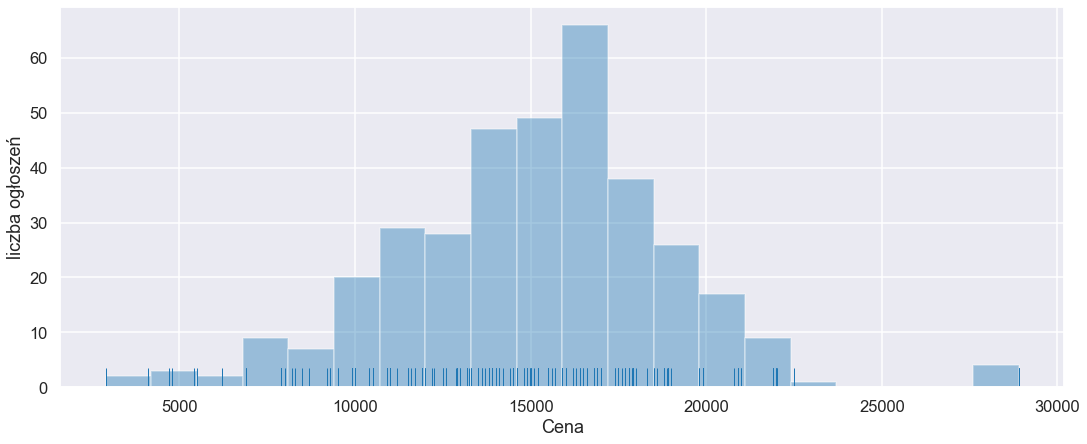

In [156]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['price'], bins=20, kde=False, rug=True)
chart.set(xlabel='Cena', ylabel='liczba ogłoszeń');

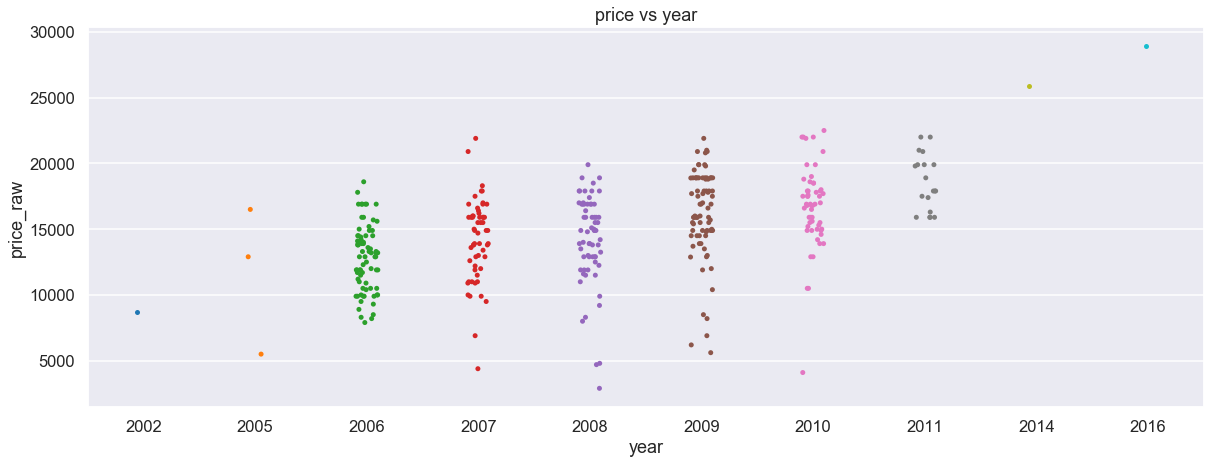

In [157]:
plt.figure(figsize=(20, 7))
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price') 
sns.stripplot(x="year", y="price_raw", data=df);


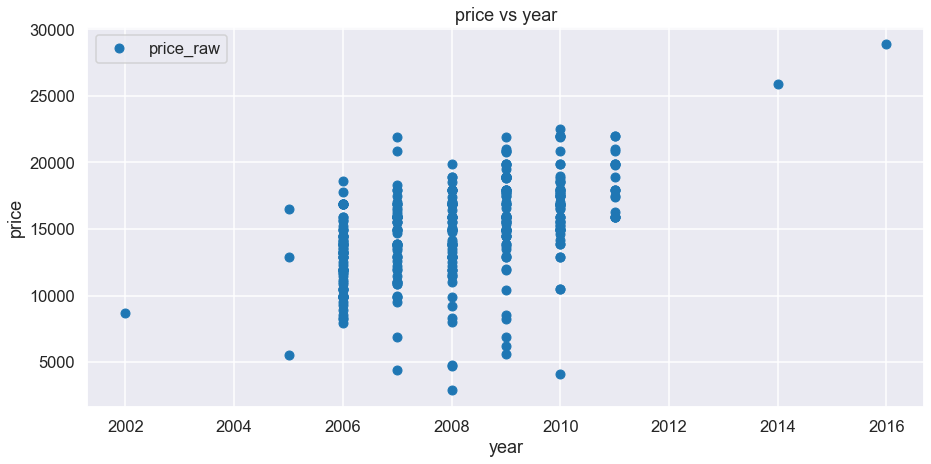

In [158]:
df.plot(x='year', y='price_raw', style='o', figsize=(15,7)) 
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price')  
plt.show()

### przebieg

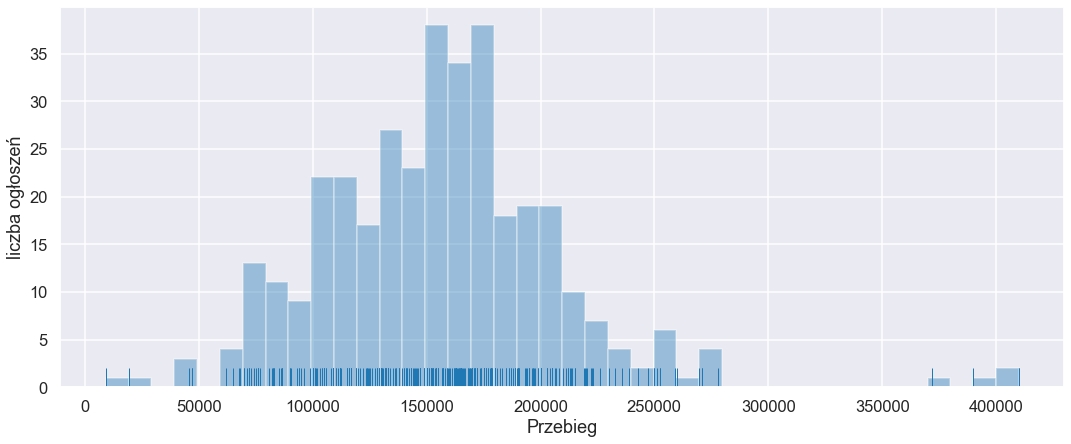

In [159]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['mileage'], bins=40, kde=False, rug=True)
chart.set(xlabel='Przebieg', ylabel='liczba ogłoszeń');

### Czas trwania ogłoszenia

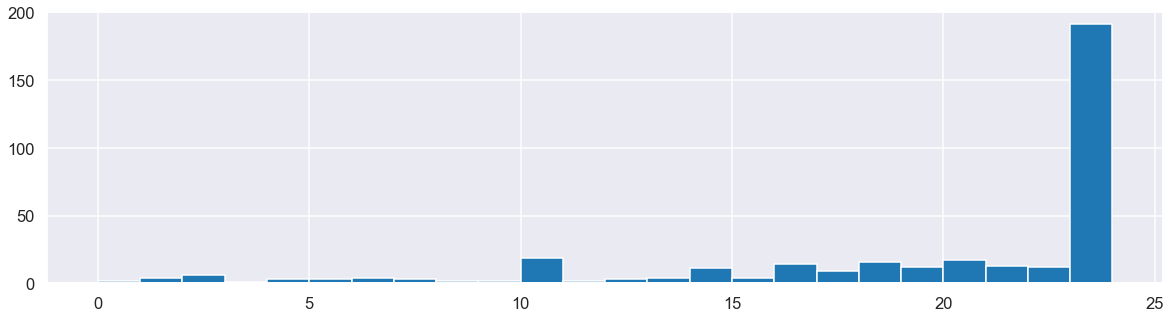

In [160]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

### Cena końcowa - 99 percentyl

In [161]:
filter_max = np.percentile(df['price'],99)
filter_max

25315.999999999985

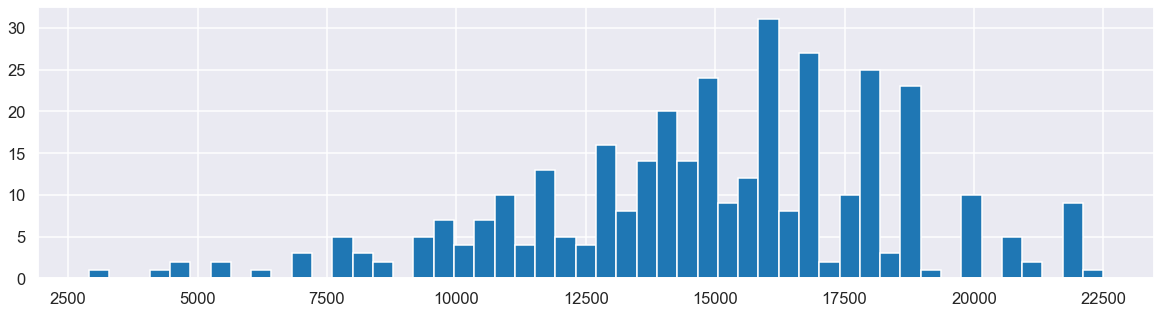

In [162]:
df_filter = df[df['price'] < filter_max]
df_filter['price'].hist(bins=50,figsize=(20,5))
plt.show()

### Przebieg

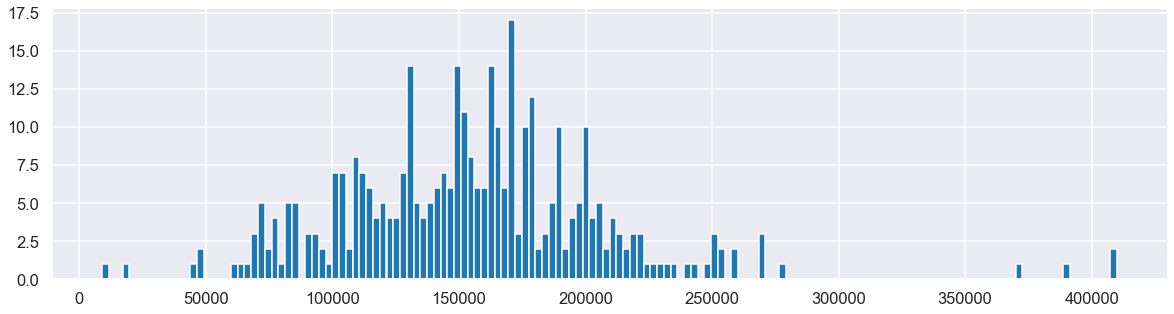

In [163]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

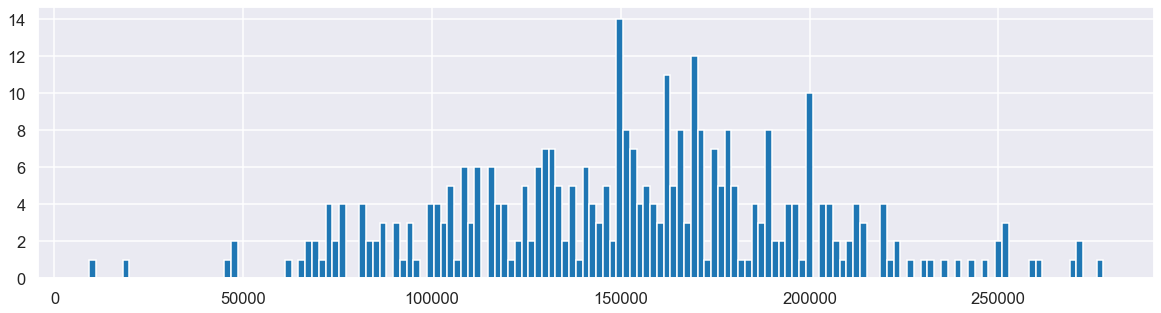

In [164]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

In [165]:
df[df['year'] == 2009 ].shape[0]

79

Wall time: 151 ms


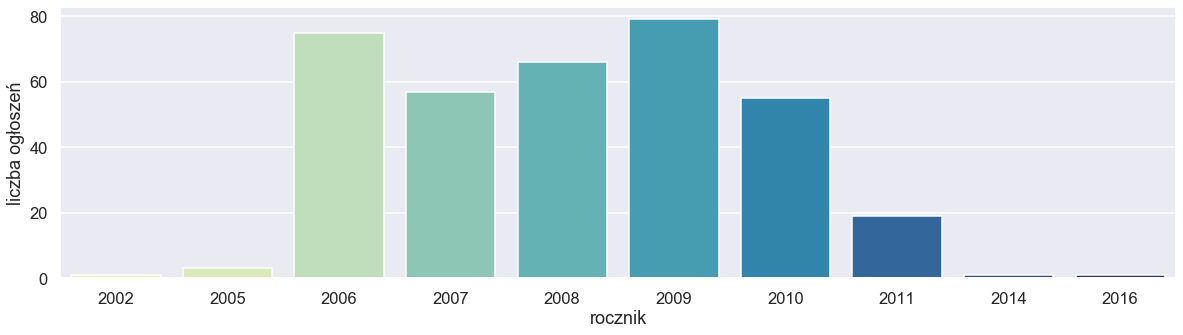

In [166]:
def plot_year():
    year_list = df['year'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['year'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='rocznik', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns.png')
    
%time plot_year()


Wall time: 269 ms


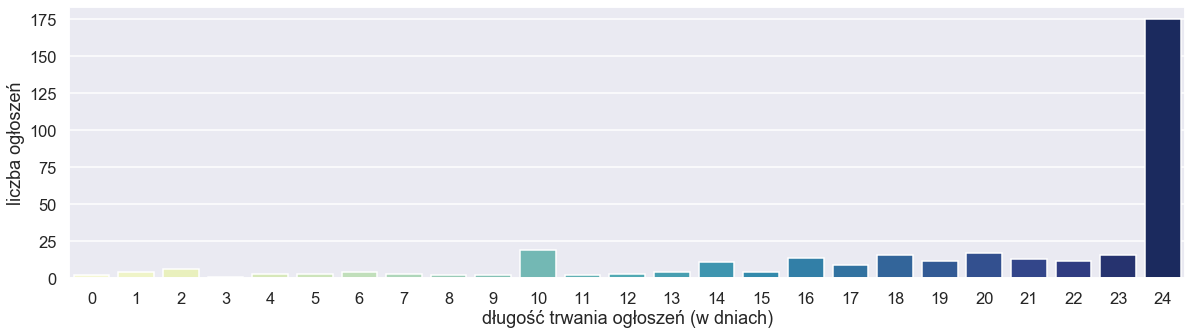

In [167]:
def plot_duration():
    year_list = df['duration'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['duration'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='długość trwania ogłoszeń (w dniach)', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns_duration.png')
    
%time plot_duration()

---

## TODO: ML

In [168]:
import random as rn
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

import joblib

seed = 0
np.random.seed(seed)
rn.seed(seed)

xgb_params = {
    'max_depth' : 5, 
    'n_estimators' : 100, 
    'learning_rate' : 0.3, 
    'random_state' : 0
}

model = xgb.XGBRegressor(**xgb_params, objective ='reg:squarederror')

In [37]:
xgb.__version__

'1.0.2'

['private_business', 'year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_automatic-air-conditioning', 'f_automatic-lights', 'f_sd-socket', 'f_front-heated-seats', 'f_onboard-computer', 'f_original-radio', 'f_abs', 'f_bluetooth', 'f_electronic-immobiliser', 'f_front-airbags', 'f_electronic-rearview-mirrors', 'f_central-lock', 'f_assisted-steering', 'f_side-window-airbags', 'f_cruise-control', 'f_automatic-wipers', 'f_rear-parking-sensors', 'f_heated-windshield', 'f_heated-rearview-mirrors', 'f_roof-bars', 'f_alarm', 'f_park-assist', 'f_cd', 'f_front-passenger-airbags', 'f_0', 'f_fog-lights', 'f_electric-exterior-mirror', 'f_gps', 'f_rear-electric-windows', 'f_head-display', 'f_towing-hook', 'f_driver-knee-airbag', 'f_aux-in', 'f_steering-whell-comands', 'f_asr', 'f_rear-passenger-airbags', 'f_velour-interior', 'f_cd-changer', 'f_dual-air-conditioning', 'f_front-electric-windows', 'f_daytime-lights', 'f_esp', 'f_usb-socket', 'f_iso

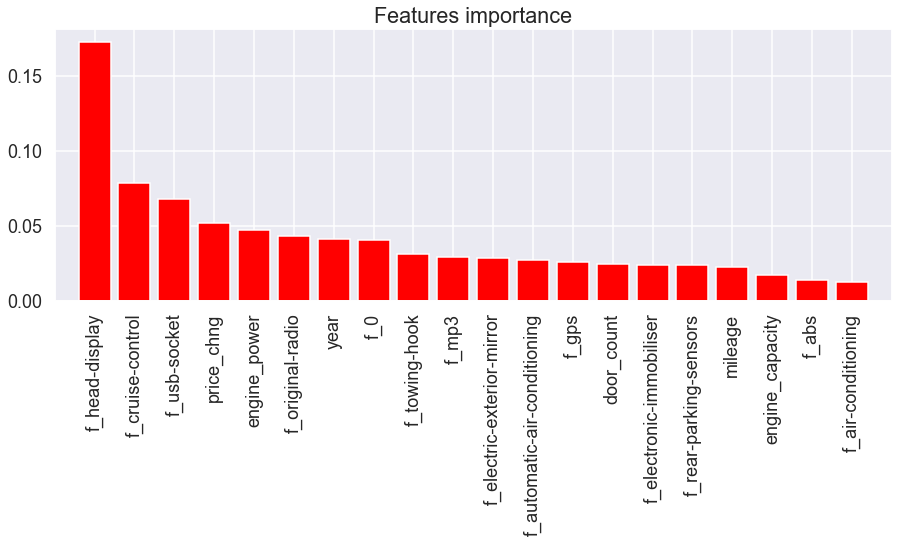

In [170]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['price', 'price_raw', 'offer_id']
    return [x for x in feats if x not in black_list]

def get_cat_feats(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    black_list = ['features', 'model']
    cat_feats_list =  [x for x in cat_feats if x not in black_list]

    for cat_feat in cat_feats_list:
        df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

    
feats = get_feats(df)
print(feats)

X = df[feats].values
y = df['price'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test.astype(int), y_pred.astype(int)))
    #print(classification_report(y_test.astype(int), y_pred.astype(int)))   
    #print(mean_squared_error(y_test.astype(int), y_pred.astype(int)))
    
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));
    #skplt.estimators.plot_learning_curve(model, X_train, y_train,'Learning Curve',cv=5);
    #xgb.plot_importance(model.get_booster(), importance_type='gain')

%time simple_split_model(model, X, y)

In [43]:
df[feats].head(1)

,year,mileage,engine_capacity,engine_power,door_count,nr_seats,duration,price_chng,f_0,f_system-start-stop,...,f_driver-knee-airbag,f_alarm,f_cruise-control,f_towing-hook,f_steering-whell-comands,f_shift-paddles,f_isofix,f_dual-air-conditioning,f_abs,f_asr
0,2009,111000,1000,0,5,5,7,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# save model
joblib.dump(model, './models/yaris_200405.pkl') 


['./models/yaris_200405.pkl']

In [46]:
model.save_model('./models/yaris.json')

In [41]:
car_info = pd.DataFrame(columns = feats)
car_info = car_info.append({'year' : '2008' , 'mileage' : 145000, 'f_gps':0 } , ignore_index=True)
car_info

,year,mileage,engine_capacity,engine_power,door_count,nr_seats,duration,price_chng,f_front-side-airbags,f_velour-interior,...,f_bluetooth,f_central-lock,f_0,f_isofix,f_rear-parking-sensors,f_leds,f_cruise-control,f_system-start-stop,f_heated-windshield,f_mp3
0,2008,145000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
y_pred = model.predict(car_info.values)
y_pred

array([15963.209], dtype=float32)

In [43]:
#load model & predict
loaded_model = joblib.load('./models/yaris_200405.pkl')
result = loaded_model.predict(car_info.values)
print('Cena powinna wynosić: ',result[0])

Cena powinna wynosić:  15963.209


In [37]:
print(X[0].shape)

(62,)


In [80]:
get_cat_feats(df)
feats = get_feats(df)
print(feats)

['year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_onboard-computer', 'f_0', 'f_asr', 'f_esp', 'f_head-display', 'f_park-assist', 'f_roof-bars', 'f_bluetooth', 'f_daytime-lights', 'f_electric-interior-mirror', 'f_sd-socket', 'f_side-window-airbags', 'f_heated-rearview-mirrors', 'f_automatic-air-conditioning', 'f_aux-in', 'f_automatic-wipers', 'f_front-electric-windows', 'f_front-passenger-airbags', 'f_gps', 'f_front-heated-seats', 'f_isofix', 'f_central-lock', 'f_driver-knee-airbag', 'f_alarm', 'f_alloy-wheels', 'f_heated-windshield', 'f_electronic-rearview-mirrors', 'f_electronic-immobiliser', 'f_assisted-steering', 'f_leds', 'f_fog-lights', 'f_rear-electric-windows', 'f_shift-paddles', 'f_velour-interior', 'f_electric-adjustable-seats', 'f_cd-changer', 'f_mp3', 'f_front-airbags', 'f_rear-parking-sensors', 'f_cd', 'f_rear-passenger-airbags', 'f_steering-whell-comands', 'f_tinted-windows', 'f_system-start-stop', 'f_dual-air-con

In [74]:
df[df['f_usb-socket'] == 1]

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_driver-knee-airbag,f_alarm,f_cruise-control,f_towing-hook,f_steering-whell-comands,f_shift-paddles,f_isofix,f_dual-air-conditioning,f_abs,f_asr
14,6055607995,2020-04-23,2020-04-24,business,slaskie,zawiercie,yaris,2010,159500,1300,...,0,1,1,1,0,0,1,0,1,1
36,6061613472,2020-04-17,2020-04-22,business,opolskie,nysa,yaris,2010,166567,1300,...,0,1,0,0,0,0,1,0,1,1
57,6066265253,2020-04-17,2020-04-24,business,pomorskie,lebork,yaris,2010,146250,998,...,0,1,0,0,0,0,0,0,1,1
62,6066936383,2020-04-17,2020-04-24,private,pomorskie,koscierzyna,yaris,2009,213285,1329,...,0,0,0,0,0,0,1,0,1,1
69,6067468696,2020-04-17,2020-04-21,business,wielkopolskie,pila,yaris,2011,173453,1400,...,1,1,0,0,1,0,1,0,1,1
85,6068055441,2020-04-22,2020-04-24,business,wielkopolskie,pleszew,yaris,2010,162641,1400,...,0,1,1,0,1,0,1,0,1,0
141,6069777341,2020-04-17,2020-04-24,business,dolnoslaskie,zabkowice-slaskie,yaris,2008,119000,998,...,1,0,0,0,1,0,1,0,1,0
165,6070704518,2020-04-17,2020-04-24,private,swietokrzyskie,staszow,yaris,2002,206261,1400,...,1,1,0,0,1,0,1,0,1,1
171,6070774728,2020-04-17,2020-04-24,business,malopolskie,krakow,yaris,2008,165000,1296,...,0,0,0,0,1,0,1,0,1,0
173,6070820213,2020-04-17,2020-04-24,private,mazowieckie,zyrardow,yaris,2011,67522,1329,...,1,1,0,0,1,0,1,0,1,1
